In [1]:
import sys; sys.path.insert(0, "../"); from utils import *
import pickle

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pde_diff import *
import robust_PDE_FIND
from robust_PDE_FIND import TrainSTRidge, compute_err, print_pde, RobustPCA, Robust_LRSTR
import scipy.io as sio

Running Python 3.9.8
You can use npar for np.array
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['save', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Loading KdV dataset
data = pickle_load('../deephpms_data/KdV_simple2.pkl')

t = data['t']
x = data['x']

idx_x = np.arange(len(x))
# idx_x = idx_x[idx_x%1==0]
idx_t = np.arange(len(t))
# idx_t = idx_t[t<=7.6]

x = x[idx_x]
t = t[idx_t]

time_dims = t.shape[0]
spatial_dims = x.shape[0]

total_points = time_dims*spatial_dims
print("Total data points:", total_points)

X, T = np.meshgrid(x, t)
Exact = data['u'].T
u = Exact[idx_x][:, idx_t]

Loaded from ../deephpms_data/KdV_simple2.pkl
Total data points: 64128


<ipython-input-3-043101efdaba>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig1.gca(projection='3d')


Text(0.5, 0, 't')

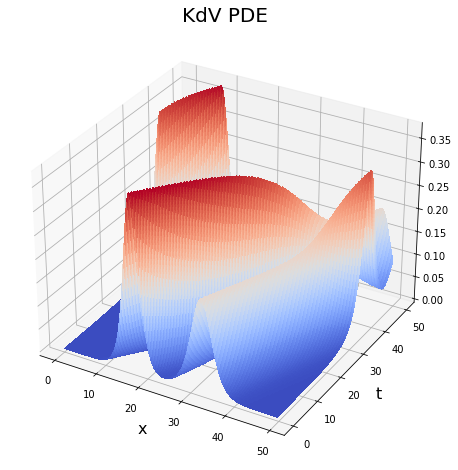

In [3]:
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('KdV PDE', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

In [4]:
dt = t[1]-t[0]
dx = x[2]-x[1]
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=5, time_diff = 'FD', space_diff = 'FD')

In [5]:
w = TrainSTRidge(R, Ut, 10**-5, 5)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_small_KdV/../robust_PDE_FIND.py:845: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_small_KdV/../robust_PDE_FIND.py:890: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_small_Kd

PDE derived using STRidge
u_t = (-6.020770 +0.000000i)uu_{x}
    + (-1.006927 +0.000000i)u_{xxx}
   


In [6]:
errs = 100*np.abs(npar([(-6.020770+6)/6, -1.006927+1]))
errs.mean(), errs.std()

(0.5194333333333263, 0.17326666666666418)

In [7]:
noise_intensity = 0.01
np.random.seed(0)
un = perturb(u, noise_intensity)

In [8]:
# The poly diff is less accurate than nn diff!?
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=5, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 10, deg_x = 5)
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,5)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-72.525038 +0.000000i)u^3u_{x}
   
